# Functional Connectivity Analysis
***

Now we have an idea of three important components to analyzing neuroimaging data:

1. Data manipulation
2. Cleaning and confound regression
3. Parcellation and signal extraction

In this notebook the goal is to integrate these 3 basic components and perform a full analysis of group data using **Intranetwork Functional Connectivity (FC)**. 

Intranetwork functional connectivity is essentially a result of performing correlational analysis on mean signals extracted from two ROIs. Using this method we can examine how well certain resting state networks, such as the **Default Mode Network (DMN)**, are synchronized across spatially distinct regions. 

ROI-based correlational analysis forms the basis of many more sophisticated kinds of functional imaging analysis.

## Notebook Outline
***

The outline of the notebook is divided into two parts. The first part directly uses what you've learned and builds upon it to perform the final functional connectivity analysis on group data. 

The second part shows how we can use Nilearn's convenient wrapper functionality to perform the same task with *significantly less effort*. 

#### Part A: Manual computation 
1. Functional data cleaning and confound regression
2. Applying a parcellation onto the data
3. Computing the correlation between two ROI time-series


#### Part B: Using Nilearn's high-level features
1. Using NiftiLabelsMasker to extract cleaned time-series
2. Computing the correlation between two ROI time-series
3. Performing analysis on all subjects
4. Visualization of final results

## The Assignment

The first couple of bits in this notebook are a review of everything you've covered in the course so far! To solidify the concepts you've learned so far we've coverted this notebook into a guided assignment!

If you have questions we recommend you take the following steps ***before asking an instructor!***

**Forgot how to do something?**
- Review previous notebooks, these contain most of the information you'll need to do assignments

**Don't know how a function works?**
- Use `SHIFT-TAB` after opening a bracket to view the help documentation
- Use the power of `Google` and just type in the function, you will almost definitely find the documentation page for that function!
- Refer to Nilearn's documentation: https://nilearn.github.io/modules/reference.html. This contains information about *all* of nilearn's functions!

**Running into an error? Here are some debugging tips for you!**

1. If you run into an issue, *always check your variables!* It may be that you:
    a. Forgot to set a variable ("variable" not defined error)
    b. There was a typo somewhere earlier in the code (i.e if the variable is the wrong size, or is a list with no elements)
    c. If you're dealing with images or arrays, then using the `.shape` property is essential to knowing whether your data is what you expect it to be!
    
**Still need help figuring it out?**

Ask in the chat! 

Feel free to answer other people's questions, we (the instructors) will step in if things get too complicated!    

In [1]:
from nilearn import image as img
from nilearn import plotting as plot
import numpy as np
import pandas as pd
from bids import BIDSLayout

In [2]:
#Pick a single subject
fmriprep_dir = '../data/ds000030/derivatives/fmriprep'
sub = '10171'

In [3]:
#Use PyBIDS to parse BIDS data structure
layout = BIDSLayout(fmriprep_dir, validate=False)

/home/a/arisvoin/jerroldj/.virtualenvs/sdc_bids_fmri/lib/python3.6/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


Use `layout.get` to pull the MNI152NLin2009cAsym files as well as the confound tsv file! 

Remember the confound tsv file doesn't have a "space" associated with it!

**HINT**:
Use `return_type="file"` so that you get a list of file paths rather than a list of "BIDS" file objects. 

If you don't use `return_type="file"`, you may need to use `.path` after pulling an element from the list.

In [4]:
#Get resting state data (preprocessed, mask, and confounds file)
func_files = layout.get(subject=sub, datatype='func', task='rest',  suffix='preproc', space='MNI152NLin2009cAsym', return_type='file')
mask_files = layout.get(subject=sub, datatype='func', task='rest', suffix='brainmask', space='MNI152NLin2009cAsym', return_type='file')
confound_files = layout.get(subject=sub, datatype='func', task='rest', suffix='confounds', return_type='file')

***
Note that when we use return_type='file' when using <code>layout.get</code> we no longer need to use <code>confound_files.path</code>. We could technically use this on all the files!
***

In [5]:
#Select MNI files
func_file = func_files[0]
mask_file = mask_files[0]
confound_file = confound_files[0]

### Part A: Manual Computation of Functional Connectivity
***

#### 1. Cleaning your functional data using filtering, dummy TR removal and confound regression
The first step to any functional analysis is to clean the data

We'll define a function to help extract our confound regressors from the .tsv file for us

In [6]:
#Refer to part_06 for code + explanation
def extract_confounds(confound_tsv,confounds,dt=True):
    '''
    Arguments:
        confound_tsv                    Full path to confounds.tsv
        confounds                       A list of confounder variables to extract
        dt                              Compute temporal derivatives [default = True]
        
    Outputs:
        confound_mat                    
    '''
    
    #Load in data using Pandas then extract relevant columns
    confound_df = pd.read_csv(confound_tsv,delimiter='\t') 
    confound_df = confound_df[confounds]
    
    #If using temporal derivatives 
    if dt:
        #For each column create a new column '<colname>_dt' containing the step-wise differences
        for col in confound_df.columns:
            confound_df['{}_dt'.format(col)] = confound_df[col].diff() 
    
    #Convert into a matrix of values (timepoints)x(variable)
    confound_mat = confound_df.values 
    
    #Return confound matrix
    return confound_mat
    

### Exercise:
Let's clean our data!

Settings to use:
- Confounders: X, Y, Z, RotX, RotY, RotZ, aCompCor01, aCompCor02, Global Signal
- Temporal Derivatives: Yes
- high_pass = 0.009
- low_pass = 0.08
- detrend = True
- standardize = True

In [7]:
#Load functional image
tr_drop = 4
func_img = img.load_img(func_file)
func_img = func_img.slicer[:,:,:,tr_drop:]

#Extract confounds
confounds = extract_confounds(confound_file,['X','Y','Z','RotX','RotY','RotZ','GlobalSignal',
                                            'aCompCor01','aCompCor02'])
confounds = confounds[tr_drop:,:] 

#Clean functional image
clean_img = img.clean_img(func_img,confounds=confounds,low_pass=0.08,high_pass=0.009,t_r=2,
                         mask_img=mask_file) 

/scinet/niagara/software/2019b/opt/base/python/3.6.8/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


#### 2. Setting up the parcellation scheme

To apply a parcellation we'll have to specify a parcellation to use. 
For this analysis we'll be using a spatially separated version [Yeo 2011 - 7 Networks](https://www.ncbi.nlm.nih.gov/pubmed/21653723).

We chose this parcellation since it nicely characterizes the **DMN**, our network of interest.  

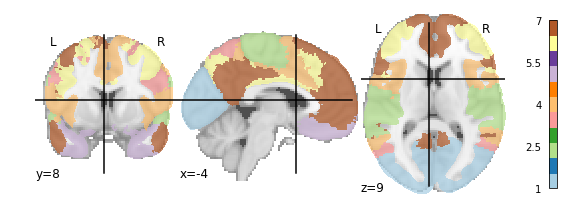

In [8]:
#Examine the original Yeo7 parcellation
net7 = '../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz'
plot.plot_roi(net7,cmap='Paired',colorbar=True)

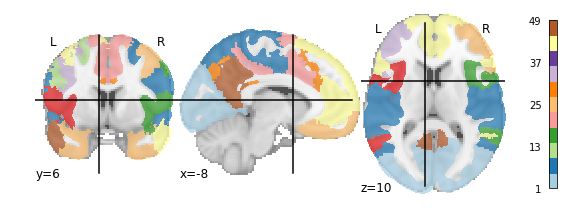

In [9]:
#Load in the spatially separated Yeo 2011 7 networks and view

parcel_file = '../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz' 
yeo_7 = img.load_img(parcel_file)
plot.plot_roi(yeo_7,cmap='Paired',colorbar=True) 

Remember that in order to use the parcellation with our functional data it must have the same dimensions. It turns out that the parcellation schema has slightly different dimensions, so we need to resample: 

In [10]:
#We use "nearest" to preserve the label values (a label of 2.42 for example, doesn't and shouldn't exist) 
resamp_yeo7 = img.resample_to_img(yeo_7,clean_img,interpolation='nearest') 
print(resamp_yeo7.shape)
print(clean_img.shape)

(65, 77, 49)
(65, 77, 49, 148)


#### 3. Intra-network functional connectivity analysis
Intra-network functional connectivity analysis is determined by computing the correlation between the mean time-series of two spatially distinct regions within the same network. 

To perform this analysis requires a few simple steps:
1. Select 2 ROIs from the same network (DMN) 
2. Extract the mean time-series from both regions 
3. Compute the correlation between the two mean ROI time-series

The first step is to select two ROIs from the DMN. We've already gone through the hassle of selecting these two regions but many possible combinations exist. 

In [11]:
#Select two ROIs and visualize
source_ROI = 44
target_ROI = 46

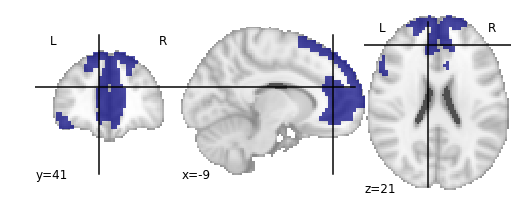

In [12]:
#Visualize the ROI, we can do this by masking our all values not matching our ROI
source_mask = img.math_img('a == {}'.format(source_ROI), a=resamp_yeo7) 

#Apply the mask to the parcellation atlas (resamp_yeo7)
masked_source = img.math_img('a*b',a=resamp_yeo7,b=source_mask) 

#Visualize
plot.plot_roi(masked_source) 

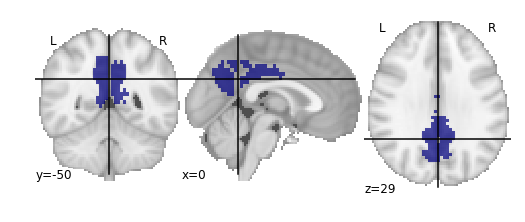

In [13]:
target_mask = img.math_img('a == {}'.format(target_ROI),a=resamp_yeo7)
masked_target = img.math_img('a*b',a=resamp_yeo7,b=target_mask)
plot.plot_roi(masked_target)

With our two regions selected, we'll now extract the mean time-series for each of our two ROIs

In [14]:
#Recall that in the parcellation, each voxel is labelled with a number corresponding to a distinct parcel
#We want to extract parcels belonging to our ROI.

#Pull the voxels indices belonging to the ROI 
yeo7_data = resamp_yeo7.get_data() 

#Get voxel coordinates (x,y,z) list of source and target ROIs
source_roi = np.where(yeo7_data == source_ROI)
target_roi = np.where(yeo7_data == target_ROI)

#Load up functional data to extract ROI voxels from
func_data = clean_img.get_data()

#Extract the list of voxel time-series belonging to each ROI
#This is now a (roi voxel)x(timepoints) array
source_ts = func_data[source_roi]
target_ts = func_data[target_roi] 

#We want to compute the mean timeseries of each list of voxels (source and target) 
#This will be a (1) x (timepoints) vector
mean_source_ts = np.mean(source_ts,axis=0)
mean_target_ts = np.mean(target_ts,axis=0) 

/home/a/arisvoin/jerroldj/.virtualenvs/sdc_bids_fmri/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """
/home/a/arisvoin/jerroldj/.virtualenvs/sdc_bids_fmri/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':


Now we've extracted two average time-series, one from the source, and one from the target.
The last step is to compute the correlation between them. This will tell us how well the average time-series from the two DMN regions synchronize with each other.

**Guide to complete these cells**

In the above cell we calculated for each of our ROIs a mean time-series signal in the form of `mean_source_ts` and `mean_target_ts`. First let's check the `shape` of these time-series (1-D arrays)

In [15]:
# Print the shapes of mean_source_ts and mean_target_ts
print(mean_source_ts.shape)
print(mean_target_ts.shape)

(148,)
(148,)


We have 2 1-D arrays of the same shape!


To calculate the **Functional Connectivity** of our two regions of interest we need to calculate the correlation between our source ROI, `mean_source_ts` and our target `mean_target_ts`

To do this we use <code>np.corrcoef(x,y)</code> which returns a matrix of form:

$$ \rho=
\left( \begin{matrix}
\rho_{1,1} & \rho_{1,2} \\
\rho_{2,1} & \rho_{2,2}
\end{matrix} \right)
$$

The diagonals represent the correlation of signals with themselves. These are always $1$. The off-diagonal represents the correlation of one signal with another is exactly what we want. In addition the matrix is symmetric so: $\rho_{1,2} = \rho_{2,1}$. 

Run the following cell to get the documentation of np.corrcoef!

In [16]:
?np.corrcoef

Now implement `np.corrcoef` to calculate the correlation coefficients of the `mean_source_ts` and `mean_target_ts`!

In [17]:
#Compute correlation and pull the value in the first row, second column
correlation_matrix = np.corrcoef(mean_source_ts,mean_target_ts)
print("The shape of the matrix is:", correlation_matrix.shape)
print(correlation_matrix)

The shape of the matrix is: (2, 2)
[[1.         0.41188849]
 [0.41188849 1.        ]]


Notice our correlation matrix is a 2x2 array! Which one of the 4 values is the connectivity/correlation between our two regions of interest?

Refer to the text above to get a hint about which value to look at! We can pick and choose values from our matrix using 2 indices:

`correlation_matrix[i,j]`

Where `i` refers to which row to look at and `k` refers to which column to look at

In [18]:
connectivity = correlation_matrix[0,1]
print(connectivity)

0.4118884885356344


### Part A: Completed!

Hopefully **Part A served as good review toward re-familiarizing yourself with parcellations/cleaning/data manipulation**. In addition it turns out that Functional Connectivity is really *just a correlation between two time-series signals*!

In the next section, we'll go over how `nilearn` greatly simplifies all the steps you just did!

### Part B: Using nilearn's label masker to extract the timeseries
***
nilearn has a built in function for extracting timeseries from functional files and doing all the extra signal processing at the same time! It's everything you just did, **all in one step!**

First we import a package from <code>nilearn</code>, called <code>input_data</code> which allows us to pull data using the parcellation file, and at the same time applying data cleaning!

We first create an object using the parcellation file <code>yeo_7</code> and our cleaning settings which are the following:

Settings to use:
- Confounders: X, Y, Z, RotX, RotY, RotZ, aCompCor01, aCompCor02, Global Signal
- Temporal Derivatives: Yes
- high_pass = 0.009
- low_pass = 0.08
- detrend = True
- standardize = True


In [19]:
from nilearn import input_data

masker = input_data.NiftiLabelsMasker(labels_img=yeo_7,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      verbose=1,
                                      detrend=True,
                                     low_pass = 0.08,
                                     high_pass = 0.009,
                                     t_r=2)

The object <code>masker</code> is now able to be used on *any functional image of the same size*. What it means to *use the masker* is that you can automatically *apply a parcellation and extract data at the same time*.

### Using nilearn's ConnectivityMeasure to calculate our correlation matrix

The second step is to compute the functional connectivity (correlation) matrix. When we use <code>masker</code>, we can compute the correlation matrix *between all ROIs in our parcellation atlas at the same time*. Below we'll show an example on how to use the <code>masker</code> in order to compute correlations on our data:

First we'll automatically clean and average data for each of our ROIs at the same time. This is done using <code>masker.fit_transform</code>:

**Guide**

Remember to hit `Shift-TAB` while the cursor is inside the brackets in order to view the help dialog for the function!

In [20]:
cleaned_and_averaged_time_series = masker.fit_transform(func_img, confounds)
cleaned_and_averaged_time_series.shape

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
Resampling labels


(148, 46)

Just to be clear, this data is *automatically parcellated for you, and, in addition, is cleaned using the confounds you've specified already!*

Then using this data we can calculate a *full correlation matrix* - this is the correlation between *all pairs of ROIs* in our parcellation scheme! We'll use another nilearn tool called <code>ConnectivityMeasure</code> from <code>nilearn.connectome</code>

In [21]:
from nilearn.connectome import ConnectivityMeasure

Like the masker, we need to make an object that will calculate connectivity for us.

**Recall from the earlier section: Functional connectivity is just a ________?** 

**Also `SHIFT-TAB` to see what options you can put into the `kind` argument of `ConnectivityMeasure`**

In [22]:
correlation_measure = ConnectivityMeasure(kind='correlation')

Then we use <code>correlation_measure.fit_transform()</code> in order to calculate the full correlation matrix for our parcellated data!

In [23]:
full_correlation_matrix = correlation_measure.fit_transform([cleaned_and_averaged_time_series])
full_correlation_matrix.shape

(1, 46, 46)

***
Note that we're using a list <code>[cleaned_and_averaged_time_series]</code>, this is becasue <code>correlation_measure</code> works on a *list of subjects*. We'll take advantage of this later!
***

The result is a matrix which has:

- A number of rows matching the number of ROIs in our parcellation atlas
- A number of columns, that also matches the number of ROIs in our parcellation atlas

You can read this correlation matrix as follows:

- Suppose we wanted to know the correlation between ROI 30 and ROI 40
- Then Row 30, Column 40 gives us this correlation. 
- Row 40, Column 40 can also give us this correlation

This is because the correlation of $A \to B = B \to A$

***

### Exercise: Now try calculating correlation matrices for all subjects in our dataset!

We've provided some skeleton code to handle some of the logic. Try to fill in the blanks to the best of your ability!

**Note that here we're using a Python for-loop to go over *all the subjects*!**

In [24]:
subjects = layout.get_subjects()

In [25]:
pooled_subjects = []
ctrl_subjects = []
schz_subjects = []

for sub in subjects:
    func_file = layout.get(subject=sub, datatype='func', task='rest',
                           suffix='preproc', return_type='file')[0]
    
    confound_file=layout.get(subject=sub, datatype='func', task='rest',
                             suffix='confounds', return_type='file')[0]
    
    func_img = img.load_img(func_file)
    func_img = func_img.slicer[:,:,:,tr_drop:]
    
    confounds = extract_confounds(confound_file,
                                 ['X','Y','Z',
                                 'RotX','RotY','RotZ',
                                 'GlobalSignal','aCompCor01',
                                 'aCompCor02'])
    
    confounds = confounds[tr_drop:,:]
    
    time_series = masker.fit_transform(func_img,confounds)
    pooled_subjects.append(time_series)
    
    #If the subject ID starts with a "1" then they are control
    if sub.startswith('1'):
        ctrl_subjects.append(time_series)
    #If the subejct ID starts with a "5" then they are case (case of schizophrenia)
    if sub.startswith('5'):
        schz_subjects.append(time_series)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f21c4942ef0>, <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7f21c4ca7b38>, 
{ 'background_label': 0,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.009,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7f21c52677b8>,
  'low_pass': 0.08,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  'strategy': 'mean',
  't_r': 2,
  'target_affine': None,
  'target_shape': None}, confounds=array([[-0.016494, ..., -0.009632],
       ...,
       

/scinet/niagara/software/2019b/opt/base/python/3.6.8/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_

The result of all of this code is that:

1. Subjects who start with a "1" in their ID, are controls, and are placed into the `ctrl_subjects` list
2. Subjects who start with a "2" in their ID, have schizophrenia, and are placed into the `schz_subjects` list

What's actually being placed into the list? The cleaned, parcellated time series data for each subject!

A helpful trick is that we can re-use the <code>correlation_measure</code> object we made earlier and apply it to a *list of subject data*! 

In [26]:
ctrl_correlation_matrices = correlation_measure.fit_transform(ctrl_subjects)
schz_correlation_matrices = correlation_measure.fit_transform(schz_subjects)

At this point, we have correlation matrices for each subject across two populations. The final step is to examine the differences between these groups in their correlation between ROI 43 and ROI 45:

***

### Visualizing Correlation Matrices and Group Differences

An important step in any analysis is visualizing the data that we have. We've cleaned data, averaged data and calculated correlations but we don't actually know what it looks like! Visualizing data is important to ensure that we don't throw pure nonsense into our final statistical analysis

To visualize data we'll be using a python package called <code>seaborn</code> which will allow us to create statistical visualizations pretty easily

In [27]:
import seaborn as sns

We can view a single subject's correlation matrix by using <code>seaborn</code>'s <code>heatmap</code> function:

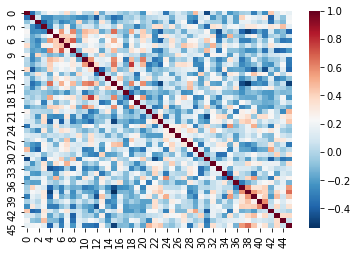

In [28]:
sns.heatmap(ctrl_correlation_matrices[0], cmap='RdBu_r')

We can now pull our ROI 44 and 46 by indexing our list of correlation matrices as if it were a 3D array (kind of like an MR volume). Take a look at the shape:

In [29]:
print(ctrl_correlation_matrices.shape)

(10, 46, 46)


This is of form:

```python
ctrl_correlation_matrices[subject_index, row_index, column_index]
```

### Exercise:

Try pulling out:

- All subjects
- Only row 43 (corresponding to ROI 44)
- Only column 45 (corresponding to ROI 46)

In [30]:
ctrl_roi_vec = ctrl_correlation_matrices[:,43,45]
schz_roi_vec = schz_correlation_matrices[:,43,45]

Seaborn visualization is best achieved using a Pandas dataframe (much like R's dataframes). A dataframe is essentially a spreadsheet-like table and is easily created using numpy arrays.

In [31]:
#Create control dataframe
ctrl_df = pd.DataFrame(data={'dmn_corr':ctrl_roi_vec, 'group':'control'})
ctrl_df.head()

,dmn_corr,group
0,0.375630,control
1,0.626689,control
2,0.609262,control
3,0.687267,control
4,0.394627,control


In [32]:
# Create the schizophrenia dataframe
scz_df = pd.DataFrame(data={'dmn_corr':schz_roi_vec, 'group' : 'schizophrenia'})
scz_df.head()

,dmn_corr,group
0,0.608327,schizophrenia
1,0.095289,schizophrenia
2,0.501292,schizophrenia
3,0.526314,schizophrenia
4,0.524979,schizophrenia


The result is:

- `ctrl_df` a table containing the correlation value for each control subject, with an additional column with the group label, which is 'control'

- `scz_df` a table containing the correlation value for each schizophrenia group subject, with an additional column with the group label, which is 'schizophrenia'

For visualization we're going to stack the two tables together

In [33]:
#Stack the two dataframes together
df = pd.concat([ctrl_df,scz_df], ignore_index=True)
df.sample(n=5)

,dmn_corr,group
11,0.095289,schizophrenia
9,0.479886,control
19,0.127753,schizophrenia
5,0.692259,control
10,0.608327,schizophrenia


Finally we're going to visualize the results using the python package `seaborn`!

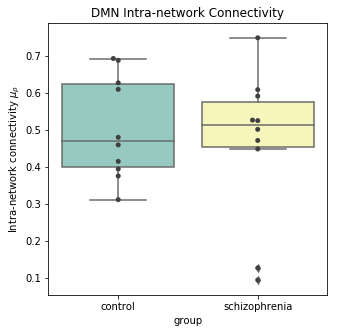

In [34]:
#Visualize results

# Create a figure canvas of equal width and height
plot = plt.figure(figsize=(5,5))
                  
# Create a box plot, with the x-axis as group
#the y-axis as the correlation value
ax = sns.boxplot(x='group',y='dmn_corr',data=df,palette='Set3')

# Create a "swarmplot" as well, you'll see what this is..
ax = sns.swarmplot(x='group',y='dmn_corr',data=df,color='0.25')

# Set the title and labels of the figure
ax.set_title('DMN Intra-network Connectivity')
ax.set_ylabel(r'Intra-network connectivity $\mu_\rho$')

# Display the figure
plt.show()

### Computing correlations was simple, but interpreting results... 
# "Science is hard" - Colin Hawco